# Generalization with OOP: The CBacktester Class

## Building the CBacktester Class from scratch: Instantiation

In [237]:
import pandas as pd
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
plt.style.use('seaborn')

In [322]:
class CBacktester():
    '''This is a docstring'''
    def __init__(self, symbol, window, start, end, tc, f):
        self.symbol = symbol
        self.window = window
        self.start = start
        self.end = end
        self.tc = tc
        self.f = f
        self.results = None
        self.get_data()
        self.prepare_data(f)
        
    def __repr__(self):
        return "CBacktester: symbol = {}, window = {}, start = {}, end = {}, tc = {}, f = {}".\
        format(self.symbol, self.window, self.start, self.end, self.tc, self.f)
        
    def get_data(self):
        raw = pd.read_csv("one_minute.csv", parse_dates = ["time"], index_col = "time")
        raw = raw[self.symbol].to_frame().fillna(method = 'ffill')#.resample("30min").mean()
        raw = raw.loc[self.start:self.end].copy()
        raw.rename(columns={self.symbol: "price"}, inplace=True)
        raw["returns"] = np.log(raw / raw.loc[:,["price"]].shift(1))
        self.data = raw
        return raw
    
    def prepare_data(self, f = None):#default value is 1 day
        if f is not None:
            self.f = f
        data = self.get_data()
        data = self.data.copy()
        data = data.price.to_frame().resample(self.f).last().dropna().iloc[:-1]
        self.data = data
    
    def set_parameters(self, window = None):
        if window is not None:
            self.window = window
            
    def test_strategy(self):
        data = self.data.copy().dropna()
        data['position'] = -np.sign(data['returns'].rolling(self.window).mean())
        data['strategy'] = data['position'].shift(1) * data['returns']
        data.dropna(inplace=True)
        data['creturns'] = data['returns'].cumsum().apply(np.exp)
        data['cstrategy'] = data['strategy'].cumsum().apply(np.exp)
        data['trades'] = data.position.diff().fillna(0).abs()
        data['ctrades'] = data.trades.cumsum()
        data['strategy_net'] = data.strategy - data.trades * (self.tc/data.price.mean())
        data['cstrategy_net'] = data.strategy_net.cumsum().apply(np.exp)
        self.results = data
        
        perf = data['cstrategy_net'].iloc[-1]
        outperf = perf - data['creturns'].iloc[-1]
        
        return round(perf, 6), round(outperf, 6)
    
    def plot_results(self):
        if self.results is None:
            print("Run test_strategy() before running plot_results()")
        else:
            self.results.loc[:,['creturns','cstrategy', 'cstrategy_net']]\
            .plot(title = "{} | {}-Bar Contrarian Window".format(self.symbol,\
            self.window),figsize=(12,8))
            
    def optimize_parameter(self, window_range):
        combinations = range(*window_range)
        
        results = []
        i = 0
        for comb in combinations:
            #Track iterations
            i+=1
            clear_output(wait=True)
            display('Iteration {} of {}. Testing window = {}'.\
            format(i, str(len(combinations)), comb))
            
            #test strategy
            self.set_parameters(comb)
            results.append(self.test_strategy()[0])
        
        #clearing output again so that there is no confusion 
        #about if the last iteration was the most optimal combination
        clear_output(wait=True)
        
        best_perf = np.max(results)
        opt = combinations[np.argmax(results)]
        
        self.set_parameters(opt)
        self.test_strategy()
        self.plot_results()
        
        many_results = pd.DataFrame(data = combinations, columns = ["window"])
        many_results['performance'] = results
        self.results_overview = many_results
        
        return opt, best_perf

In [323]:
spread = 1.5
pips = 0.0001
insample = CBacktester("EURUSD", 3, "2018-01-01", "2019-12-30", spread/2*pips, "1min") #mult by 2 for a 'round trip', multiply by pips
insample


CBacktester: symbol = EURUSD, window = 3, start = 2018-01-01, end = 2019-12-30, tc = 7.500000000000001e-05, f = 1min

In [327]:
insample.prepare_data(f = "20min")
insample.data
#insample.test_strategy()
#insample.plot_results()
#insample.results
#insample.f

,price
time,
2018-01-01 22:00:00,1.20076
2018-01-01 22:20:00,1.20155
2018-01-01 22:40:00,1.20152
2018-01-01 23:00:00,1.20145
2018-01-01 23:20:00,1.20119
...,...
2019-12-30 22:00:00,1.12040
2019-12-30 22:20:00,1.12003
2019-12-30 22:40:00,1.12012


### checkpoint: instantation, get_data, set_parameters work

In [183]:
#from lecture 107: random nose part 1
window = 44
hours = 6
hours = 60
insample.prepare_data()
insample.set_parameters()

In [184]:
insample.test_strategy()

(3.666642, 2.73376)

(7, 4.317039)

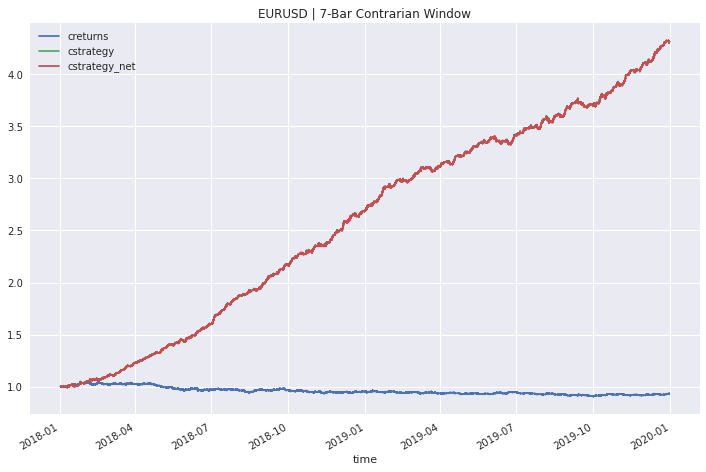

In [185]:
insample.optimize_parameter((1,252,1))

### Number of trades

In [186]:
print("From {} to {}, this strategy performed {:,.0f} trades over {:,.0f} periods, \nan average of {:.2f} trades per period.\n\n Trading costs totaled {:,.2f}.".\
format(insample.start, insample.end, insample.results.ctrades[-1], insample.results.trades.describe().loc['count'],\
       insample.results.trades.describe().loc['count'] / insample.results.ctrades[-1],spread/2*pips*insample.results.ctrades[-1]))
(insample.results.index[1]-insample.results.index[0])

From 2018-01-01 to 2019-12-30, this strategy performed 270,354 trades over 737,535 periods, 
an average of 2.73 trades per period.

 Trading costs totaled 20.28.


Timedelta('0 days 00:01:00')

### Number of trades plot

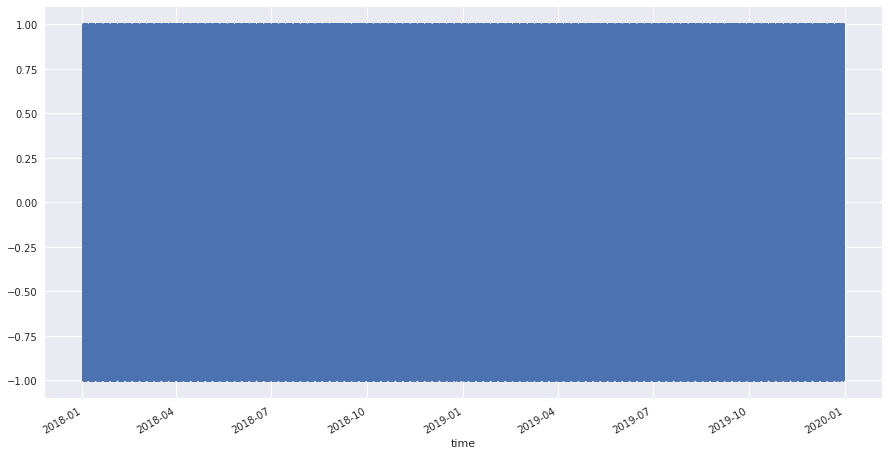

0.07155

In [187]:
insample.results['position'].plot(figsize=(15,8))
plt.show()
spread/2*pips*954

In [131]:
insample.results_overview.sort_values(by=['performance'], ascending=False).head(10)

,window,performance
43,44,1.288223
50,51,1.287378
49,50,1.265807
54,55,1.263768
53,54,1.263228
52,53,1.258961
55,56,1.256772
37,38,1.248441
51,52,1.241089
44,45,1.231257


In [217]:
insample.results.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2018 entries, 2018-01-18 22:00:00+00:00 to 2019-12-30 22:00:00+00:00
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          2018 non-null   float64
 1   returns        2018 non-null   float64
 2   position       2018 non-null   float64
 3   strategy       2018 non-null   float64
 4   creturns       2018 non-null   float64
 5   cstrategy      2018 non-null   float64
 6   trades         2018 non-null   float64
 7   ctrades        2018 non-null   float64
 8   strategy_net   2018 non-null   float64
 9   cstrategy_net  2018 non-null   float64
dtypes: float64(10)
memory usage: 173.4 KB


__AUD/EUR__

## Method get_data()

## Setting new SMA Paramters

## Testing a Strategy

## Plotting the results

## Strategy Optimization

## Splitting get_data() and adding prepare_data() 

## String Representation & Docstrings